In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
from numpy import array
%matplotlib inline
from operator import itemgetter

## Read Images

In [331]:
x_folder = 'XraySpray/0404/0404-600b-2.0ms-se-t1_C001H001S0001/'
test_base_folder = '0404-600b-2.0ms-se-t1_C001H001S0001001000.tif'
BACK_N = 9

### Read background images

In [332]:
def read_images(N):
    background = map(lambda x:
        cv2.imread(x_folder+'0404-600b-2.0ms-se-t1_C001H001S000100000%d.tif'%x,
                   cv2.IMREAD_UNCHANGED),
        range(1,N))
    print 'this is first back dtype %s'%background[0].dtype
    print background[0]
    return np.array(background,dtype=np.float64)

### Data Prep

In [333]:
def norm_I(imgs):
    return imgs.sum(axis=(0))

### Display background image

this is first back dtype uint16
[[751 719 764 ...,  38  59  46]
 [720 724 727 ...,  55  59  38]
 [718 701 713 ...,  52  53  50]
 ..., 
 [653 630 710 ..., 681 695 658]
 [641 648 677 ..., 685 673 664]
 [644 662 678 ..., 701 672 649]]
avgI
(512, 512)
[[ 749.5    723.75   763.625 ...,   61.375   60.      52.   ]
 [ 726.25   730.     727.25  ...,   61.875   58.5     54.25 ]
 [ 729.25   721.875  726.375 ...,   57.75    57.625   60.25 ]
 ..., 
 [ 663.25   644.75   711.75  ...,  696.625  697.5    689.25 ]
 [ 655.375  657.625  666.75  ...,  689.125  684.     677.   ]
 [ 647.125  663.25   686.25  ...,  716.125  682.625  659.625]]


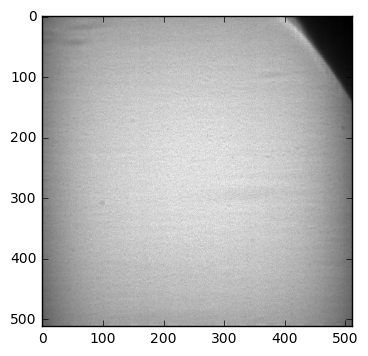

In [334]:
bI = read_images(BACK_N)
avgI = norm_I(bI)/len(bI)  
print 'avgI'
print avgI.shape
print avgI
plt.imshow(avgI,cmap='gray')

### Display test image

(512, 512)
[[776 809 814 ...,  56  68  62]
 [764 772 776 ...,  60  57  62]
 [767 744 759 ...,  56  60  70]
 ..., 
 [682 673 720 ..., 720 708 709]
 [677 709 691 ..., 712 709 695]
 [673 739 700 ..., 744 706 695]]


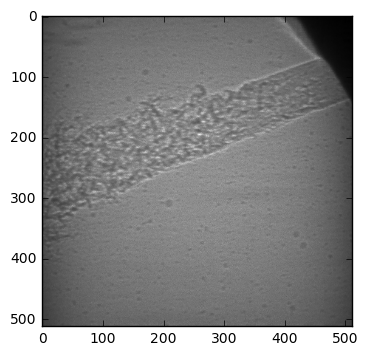

In [335]:
test_I = np.array(cv2.imread(x_folder+test_base_folder,cv2.IMREAD_UNCHANGED))
print test_I.shape
print test_I
plt.imshow(test_I,cmap='gray')

### Remove backgound noise and display image

after rescale
(512, 512)
[[ 1.0353569   1.11778929  1.06596824 ...,  0.91242363  1.13333333
   1.19230769]
 [ 1.05197935  1.05753425  1.06703334 ...,  0.96969697  0.97435897
   1.14285714]
 [ 1.05176551  1.03064935  1.04491482 ...,  0.96969697  1.04121475
   1.16182573]
 ..., 
 [ 1.02826988  1.04381543  1.01159115 ...,  1.03355464  1.01505376
   1.02865433]
 [ 1.03299638  1.07812203  1.03637045 ...,  1.03319427  1.03654971
   1.02658789]
 [ 1.03998455  1.11421033  1.02003643 ...,  1.03892477  1.03424281
   1.05362896]]


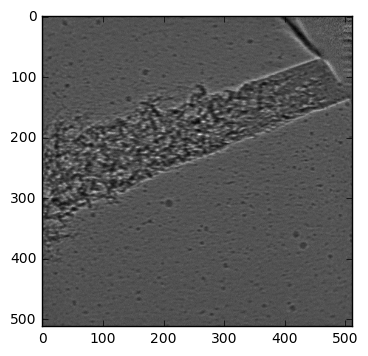

In [336]:
res_I = test_I/avgI
res_max = res_I.max()
res_min = res_I.min()
rescale_I = 255.0 * (res_I-res_min)/(res_max-res_min)
plt.imshow(res_I,cmap='gray')
print 'after rescale'
print res_I.shape
print res_I


rescaled image
(512, 512)


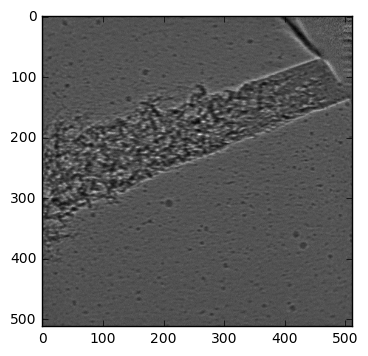

In [362]:
print 'rescaled image'
print rescale_I.shape
plt.imshow(rescale_I,cmap='gray')

## Build Filter

In [428]:
# build filter bank convolution kernels
KSIZE = [31,35]#[17,19,21,23,25,27,31,35,39,47,51]
ORIENTS = 16
PI = np.pi
OR = np.arange(0, np.pi, np.pi / ORIENTS)
def build_filters():
    filters = [] 
    
    #kernel_params = []
     # length will be len(ksize)* len(theta): 7 now
    for scale in KSIZE:
        f_s = []
        for theta in OR:
            kern = cv2.getGaborKernel((scale, scale), 4.0, 
                                      theta, 10, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum() # normalizing the kernal result

            f_s.append(kern)
        filters.append(np.array(f_s))
    return filters


## Filter results per image

In [437]:
# Note: Don't turn filtered images to type int
def process_by_image(img, f_s):
    filtered_s =[]
    final_f = []
    for f_th in f_s:
        all_filtered = []
        for kern in f_th:
            fimg = cv2.filter2D(img, -1, kern)
            all_filtered.append(fimg)
#cv2.CV_8UC3
            # all_filterd :  filtered result for all filters; find the max next
        #max_resp is a tuple with best filtered image and kernal index
        a_f = np.array(all_filtered)
        final_f.append(a_f)
        (f_max,k_ind) = max_response(a_f)
        filtered_s.append((f_max,k_ind))
    #print len(filtered_s)
    f_thM = max(filtered_s,key=itemgetter(0)) 
    #print filtered_s
    #print filtered_s.index(f_thM)
    kInd_s = filtered_s.index(f_thM)
    print kInd_s
    print f_thM[1]
    return (final_f,kInd_s,f_thM[1])  #contains all filtered, max_scale, max_orient

In [438]:
def max_response(all_filtered):
    f_sum = all_filtered.sum(axis=(1,2))
    k_ind = f_sum.argmax()
    f_max = f_sum.max()
    return (f_max,k_ind)

In [439]:
image_names = ('84.tiff')#, 'H20', 'I65', 'I200')
images = [rescale_I]#, img_2, img_3, img_4)

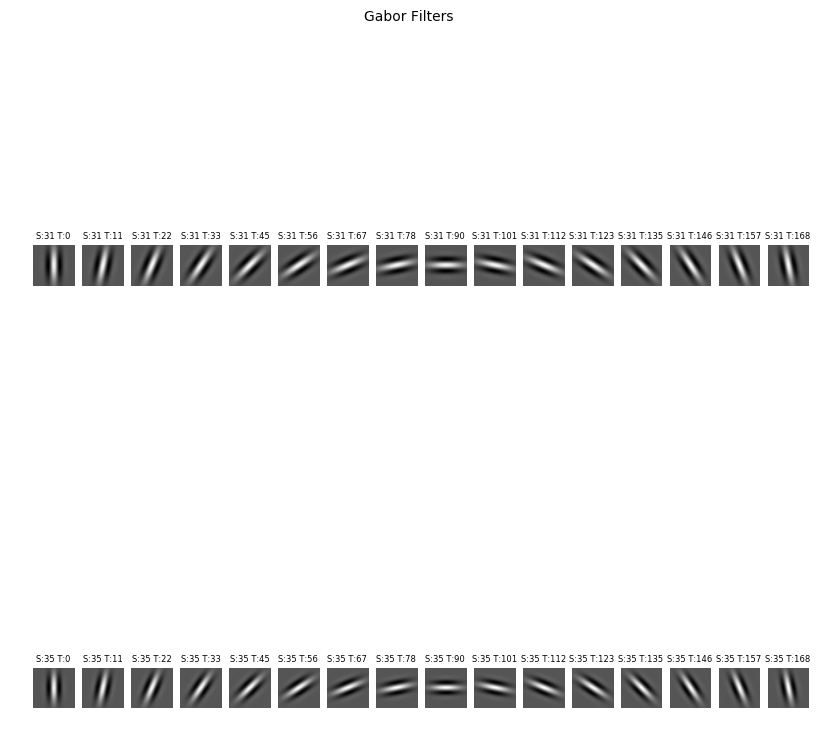

In [440]:
flts_s = build_filters()

# plot filters
fig_fil, axes_fil = plt.subplots(nrows=len(KSIZE), ncols=ORIENTS ,figsize=(10, 10))

fig_fil.suptitle('Gabor Filters', fontsize=10)

for j, f_sc in enumerate(flts_s):
    
    for i, fimg_t in enumerate(f_sc):
        ax = axes_fil[j][i]  
        th = int((np.arange(0, PI, PI / ORIENTS)[i])*(180/PI))
        title = r'S:%d T:%d' % (KSIZE[j],th)
        ax.set_title(title,fontsize=6)
        ax.imshow(fimg_t,cmap='gray')
        ax.axis('off')

### Display filtered images and the best result

In [441]:
r_img = []
for i in images:
    res = process_by_image(i, flts_s)
    r_img.append(res)

0
8


0
8


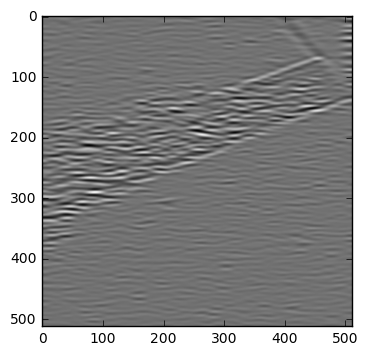

In [443]:
a = r_img[0][1]
o = r_img[0][2]
print a
print o
plt.imshow(r_img[0][0][a][o],cmap='gray')

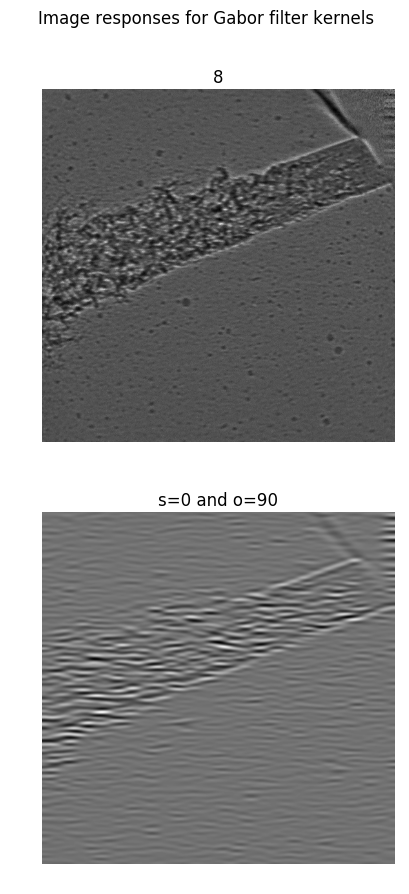

In [463]:
fig, axes = plt.subplots(nrows=2, ncols=len(images),figsize=(10, 10))

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)


for label, img in zip(image_names, images):
    ax = axes[0]
    ax.imshow(img,cmap='gray')
    ax.set_title(label, fontsize=12)
    ax.axis('off')
k =0
for i ,f_S in enumerate(r_img): 
    max_s = f_S[1]
    max_o = f_S[2]
    o1 = OR[max_o]*180/PI
    k = 0
    ax = axes[1]
    ax.axis('off')
    ax.set_title('s=%s and o=%s'%(max_s,int(o1)), fontsize=12)
    ax.imshow(f_S[0][max_s][max_o],cmap='gray')
    
    

plt.show()

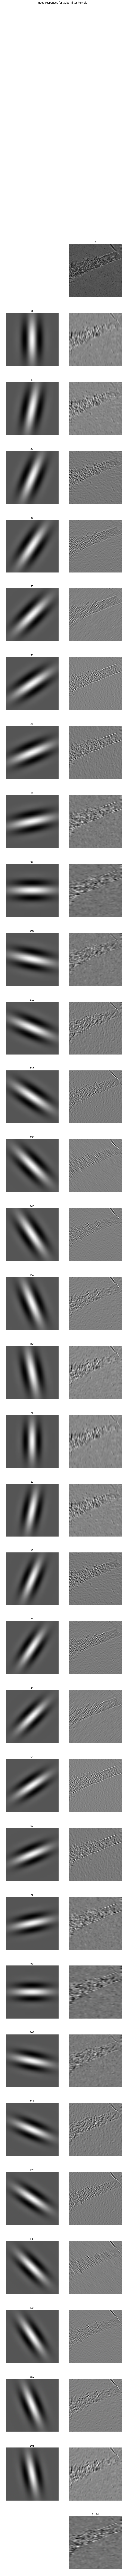

In [464]:
fig, axes = plt.subplots(nrows=len(KSIZE*ORIENTS)+2, ncols=len(images)+1,figsize=(10, 200))

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)
#fig.tight_layout()
axes[0][0].axis('off')
axes[-1][0].axis('off')
#axes[len(ksize*forients)+1][0].axis('off')

for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img,cmap='gray')
    ax.set_title(label, fontsize=12)
    ax.axis('off')
k =0
for i, flt_sc in enumerate(flts_s):   
    for j, flt in enumerate(flt_sc):
        k+=1
        ax = axes[k][0]
        th = int((np.arange(0, PI, PI / ORIENTS)[j])*(180/PI))
        ax.set_title(th, fontsize=12)
        ax.imshow(flt,cmap='gray')
        ax.axis('off')
# each r_img contains - (all filtered, max_scale, max_orient)
for i ,f_S in enumerate(r_img): 
    
    max_s = f_S[1]
    max_o = f_S[2]
    max_title = str(KSIZE[max_s])+' '+str(int(OR[max_o]*180/PI))
    k = 0
    for j, f_imgS in enumerate(f_S[0]):
        
        for l, f_imgO in enumerate(f_imgS):
            k+=1
            ax = axes[k][i+1]
            
            ax.imshow(f_imgO,cmap='gray')
            ax.axis('off')

    ax_1 = axes[-1][i+1]
    ax_1.set_title(max_title, fontsize=12)
    ax_1.imshow(f_S[0][max_s][max_o])
    ax_1.axis('off')
    plt.imshow(f_S[0][max_s][max_o],cmap='gray')
    
plt.show()